In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from datetime import datetime
from datetime import timedelta
from datetime import date

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px
import chart_studio.plotly as py

pd.set_option('display.max_columns', None)

## Model Building and Forecasting

In this section i will use a SARIMA model to try and forecast the daily power demand in kW for the entire building


In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [4]:
df_power_daily = pd.read_csv('Data/df_power_daily.csv', index_col='Date')
df_power_daily.index = pd.to_datetime(df_power_daily.index)

In [5]:
df_power_daily_total = pd.DataFrame(df_power_daily.sum(axis = 1), columns = ['kW'])
df_power_daily_total.head()

,kW
Date,
2018-07-01,3827.68
2018-07-02,9109.17
2018-07-03,8101.01
2018-07-04,7889.48
2018-07-05,7994.67


### Testing if Time Series is stationary using ADF test

In [6]:
from statsmodels.tsa.stattools import adfuller
X = df_power_daily_total['kW'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %3.f' % (key, value))
    
if result[0] < result[4]['5%']:
    print('Reject Ho - Time Series is Stationary')
else:
    print('Failed to Reject Ho - Time Series is non-Stationary')


ADF Statistic: -2.964742
p-value: 0.038321
Critical Values: 
	1%:  -3
	5%:  -3
	10%:  -3
Reject Ho - Time Series is Stationary


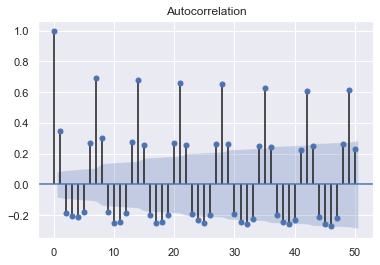

In [7]:
#Plot ACF
acf_plot = plot_acf(df_power_daily_total['kW'], lags=50)

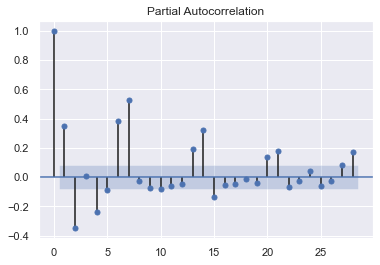

In [8]:
#Plot PACF
pacf_plot = plot_pacf(df_power_daily_total['kW'])

In [9]:
# Train 70%
train_end = df_power_daily_total.iloc[round(len(df_power_daily_total)*0.7)].name
# Test 30%
test_end = df_power_daily_total.iloc[-1].name

In [10]:
#set training data - Use all values until train_end
train_data = pd.DataFrame(columns = ['kW'],data = df_power_daily_total[:train_end])

#set testing data - Use values from train_end +1 until test_end
test_data = pd.DataFrame(columns = ['kW'], data = df_power_daily_total[train_end + timedelta(days = 1):test_end])

In [11]:
#Save index of test_data to use later
ind = test_data.index

### Fitting SARIMA model

In [12]:
#To avoid indexing error while predicting, reset index on both data sets
train_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

In [13]:
#Drop all rows with null values
train_data.dropna(inplace = True)

In [15]:
my_order =(2,1,1)
my_seasonal_order =(1,0,1,7)

model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)

In [16]:
## Fit model
from time import time
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time: ', end-start)

Model Fitting Time:  1.1648931503295898


In [17]:
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                kW   No. Observations:                  385
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3296.574
Date:                           Mon, 08 Feb 2021   AIC                           6605.149
Time:                                   23:19:51   BIC                           6628.852
Sample:                                        0   HQIC                          6614.551
                                           - 385                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3913      0.041      9.558      0.000       0.311       0.472
ar.L2         -0.1036      0.013     -8.002

In [18]:
#Set prediction preiod 
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [19]:
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)

In [20]:
#Create dataframe with Actual values, Predicted values and residuals
df_pre = pd.DataFrame(columns= ['kW_Actual'],data = test_data.values,index = ind)
df_pre['kW_Predicted'] = predictions.values
df_pre['Residuals'] = df_pre['kW_Actual'] - df_pre['kW_Predicted']

In [21]:
df_pre.head()

,kW_Actual,kW_Predicted,Residuals
Date,,,
2019-07-21,3209.20,0.000000,3209.200000
2019-07-22,8463.83,3034.778299,5429.051701
2019-07-23,8706.77,6602.059097,2104.710903
2019-07-24,7381.35,6026.802088,1354.547912
2019-07-25,7517.54,6281.565579,1235.974421


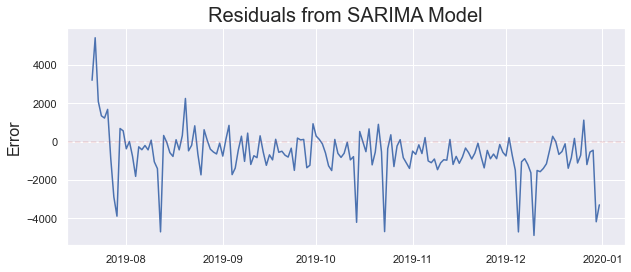

In [22]:
#Plot residuals
plt.figure(figsize = (10,4))
plt.plot(df_pre['Residuals'])
plt.title('Residuals from SARIMA Model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)

In [23]:
#Plot predicted values agains Actual values
df_pre[['kW_Actual','kW_Predicted']].iplot(yTitle='kW')

In [24]:
residuals = df_pre['kW_Predicted']- df_pre['kW_Actual']
mspe = round(np.mean(abs(residuals/df_pre['kW_Actual'])),2)*100
print(f'The root mean precent error is: \n{(mspe)}%')

The root mean precent error is: 
26.0%


## Improving Model by Accounting for Holidays and Weekends

In [25]:
df_holidays = pd.read_csv('Data/holiday_18_19.csv')
df_holidays = df_holidays.iloc[:,1:]
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays.head()

,Date,holiday
0,2018-07-27,Asalha Puja
1,2018-07-30,Beginning of Vassa
2,2018-08-13,Queen's Birthday
3,2018-10-15,H.M. King Bhumibol Adulyadej The Great Memoria...
4,2018-10-23,Chulalongkorn Memorial Day


In [26]:
#account for holidays and weekends
df_with_dummies = df_power_daily_total.copy()
df_with_dummies.reset_index(inplace = True)

df_with_dummies['year'] = df_with_dummies['Date'].apply(lambda x: x.year)
df_with_dummies['month'] = df_with_dummies['Date'].apply(lambda x: x.month)
df_with_dummies['weekday'] = df_with_dummies['Date'].apply(lambda x: x.weekday())

df_with_dummies = df_with_dummies.merge(df_holidays, how='left', on='Date')
df_with_dummies['holiday_bool'] = pd.notnull(df_with_dummies['holiday']).astype(int)
df_with_dummies = pd.get_dummies(df_with_dummies, columns = ['month','holiday','weekday'],
                          prefix = ['month','holiday','weekday'])

In [27]:
#df_with_dummies.columns

In [28]:
ext_var_list = ['Date', 'year', 'holiday_bool', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12',
       'holiday_ASEAN Summit Public Holiday', 'holiday_Asalha Puja',
       'holiday_Beginning of Vassa', 'holiday_Chakri Memorial Day',
       'holiday_Chulalongkorn Memorial Day', 'holiday_Constitution Day',
       'holiday_Coronation Day',
       'holiday_Coronation of King Maha Vajiralongkorn', 'holiday_Family Day',
       "holiday_Father's Day",
       "holiday_H.M Queen Suthida Bajrasudhabimalalakshana's Birthday",
       'holiday_H.M. King Bhumibol Adulyadej The Great Memorial Day',
       "holiday_King's Birthday", 'holiday_Labour Day', 'holiday_Māgha Pūjā',
       "holiday_New Year's Day", "holiday_New Year's Eve",
       "holiday_Queen's Birthday", "holiday_Royal Ploughing Ceremony",
       'holiday_Songkran', 'holiday_Vesak', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']

In [29]:
exog_data = df_with_dummies[ext_var_list]
exog_data = exog_data.set_index('Date')
exog_data.head()

,year,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday_ASEAN Summit Public Holiday,holiday_Asalha Puja,holiday_Beginning of Vassa,holiday_Chakri Memorial Day,holiday_Chulalongkorn Memorial Day,holiday_Constitution Day,holiday_Coronation Day,holiday_Coronation of King Maha Vajiralongkorn,holiday_Family Day,holiday_Father's Day,holiday_H.M Queen Suthida Bajrasudhabimalalakshana's Birthday,holiday_H.M. King Bhumibol Adulyadej The Great Memorial Day,holiday_King's Birthday,holiday_Labour Day,holiday_Māgha Pūjā,holiday_New Year's Day,holiday_New Year's Eve,holiday_Queen's Birthday,holiday_Royal Ploughing Ceremony,holiday_Songkran,holiday_Vesak,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-01,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2018-07-02,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018-07-03,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-07-04,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-07-05,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [30]:
df_with_dummies = df_with_dummies.set_index('Date')
df_with_dummies.head()

,kW,year,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday_ASEAN Summit Public Holiday,holiday_Asalha Puja,holiday_Beginning of Vassa,holiday_Chakri Memorial Day,holiday_Chulalongkorn Memorial Day,holiday_Constitution Day,holiday_Coronation Day,holiday_Coronation of King Maha Vajiralongkorn,holiday_Family Day,holiday_Father's Day,holiday_H.M Queen Suthida Bajrasudhabimalalakshana's Birthday,holiday_H.M. King Bhumibol Adulyadej The Great Memorial Day,holiday_King's Birthday,holiday_Labour Day,holiday_Māgha Pūjā,holiday_New Year's Day,holiday_New Year's Eve,holiday_Queen's Birthday,holiday_Royal Ploughing Ceremony,holiday_Songkran,holiday_Vesak,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-01,3827.68,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2018-07-02,9109.17,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018-07-03,8101.01,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-07-04,7889.48,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-07-05,7994.67,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [31]:
from datetime import timedelta
#set training data - Use all values until train_end

# Train 70%
train_end = df_with_dummies.iloc[round(len(df_with_dummies)*0.7)].name
# Test 30%
test_start = df_with_dummies.iloc[round(len(df_with_dummies)*0.7)+1].name

train_df = df_with_dummies['kW'][:train_end]
test_df = df_with_dummies['kW'][test_start:]

In [32]:
# fit model
model_fit = sm.tsa.statespace.SARIMAX(endog = train_df,
                                        exog = exog_data[:train_end],  
                                        trend='n',
                                        order=(4,0,6),
                                        seasonal_order=(1,0,1,7)).fit()
print(model_fit.summary())

C:\Users\moham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\moham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\moham\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                                  kW   No. Observations:                  387
Model:             SARIMAX(4, 0, 6)x(1, 0, [1], 7)   Log Likelihood               -3059.875
Date:                             Mon, 08 Feb 2021   AIC                           6229.751
Time:                                     23:20:47   BIC                           6447.464
Sample:                                          0   HQIC                          6316.080
                                             - 387                                         
Covariance Type:                               opg                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
year

In [33]:
#Set prediction preiod  - this needs to be a datetime
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

In [34]:
predictions = model_fit.forecast(steps = 165,exog = exog_data[pred_start_date:pred_end_date])

C:\Users\moham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [35]:
#Create dataframe with Actual values, Predicted values and residuals
df_pre_new = pd.DataFrame(columns= ['kW_Actual'],data = test_df.values)
df_pre_new ['kW_Predicted'] = predictions.values
df_pre_new ['Residuals'] = df_pre_new ['kW_Actual'] - df_pre_new ['kW_Predicted']
df_pre_new.index = test_df.index

In [36]:
#Plot predicted values agains Actual values
df_pre_new[['kW_Actual','kW_Predicted']].iplot(yTitle='kW')

In [37]:
residuals = df_pre_new['kW_Predicted']- df_pre_new['kW_Actual']
mspe = round(np.mean(abs(residuals/df_pre_new['kW_Actual'])),4)*100
print(f'The root mean precent error is: \n{(mspe)}%')

The root mean precent error is: 
12.1%
